# Final Project on the Hubble Ultra Deep Field (UDF f105w image)

In [45]:
import numpy as np
import sep

In [46]:
# additional setup for reading the test image and displaying plots
from astropy.io import fits
import astropy.io.fits
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

Read an UDF image from a FITS file and display it

In [47]:
# read image into standard 2-d numpy array
data = fits.getdata("hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits", ext=0)

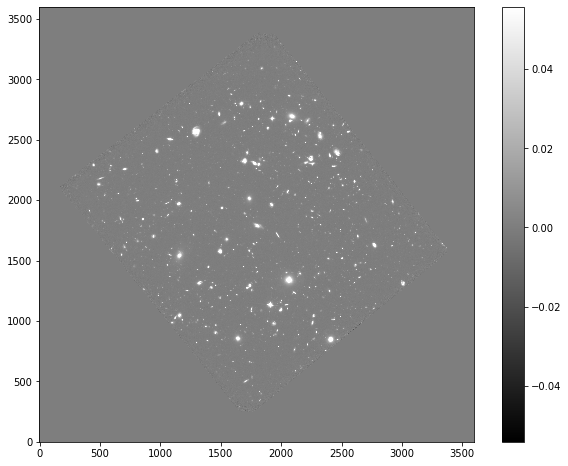

In [48]:
# show the image
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();
plt.savefig('f105wfit.png')

### Background Subtraction

In [49]:
# measure a spatially varying background on the image
data = data.byteswap().newbyteorder()
bkg = sep.Background(data)

In [50]:
# get a "global" mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)
#print(data.globalback)
#print(data.globalrms)

0.0
0.0005398219218477607


In [51]:
# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()

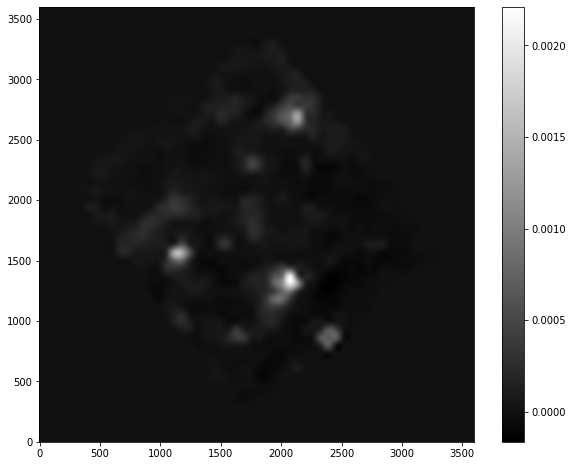

In [52]:
# show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig('f105wbkground.png')

In [53]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

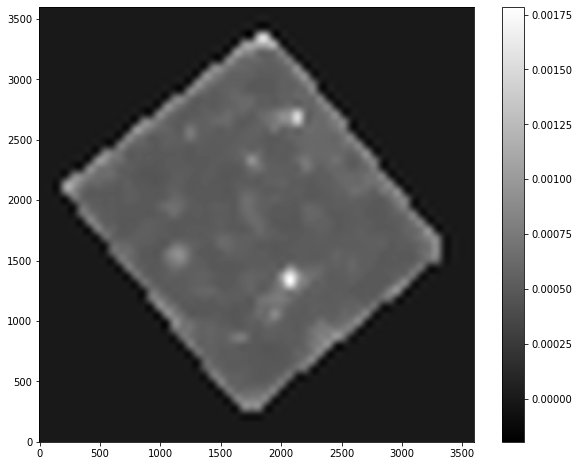

In [54]:
# show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig('f105wbkgrnoise.png')

In [55]:
# subtract the background
data_sub = data - bkg

### Object Detection

Setting the detection threshold to be a constant value of 4σ where σ is the global background RMS.

In [88]:
objects = sep.extract(data_sub, 4, err=bkg.globalrms)

#### Sources detected

In [89]:
# how many objects were detected
len(objects)

3237

To check where the detected objects are, over-plot the object coordinates with some basic shape parameters on the image

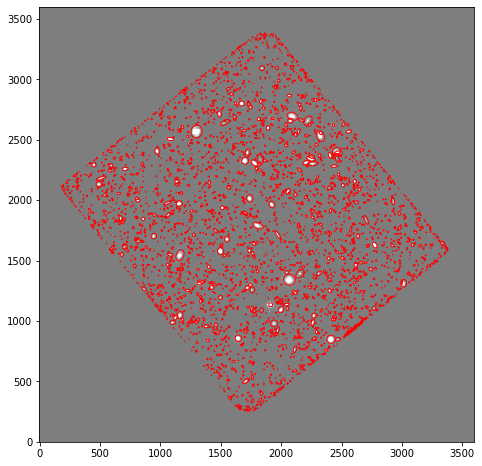

In [90]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
plt.savefig('f105wobjdetect.png')

### Aperture photometry

Perform simple circular aperture photometry with a 3 pixel radius at the locations of the objects

In [91]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

In [92]:
# show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 0.029188 +/- 0.170868
object 1: flux = 0.032885 +/- 0.181365
object 2: flux = 0.082070 +/- 0.286494
object 3: flux = 0.064379 +/- 0.253747
object 4: flux = 0.070986 +/- 0.266448
object 5: flux = 0.039688 +/- 0.199240
object 6: flux = 0.104682 +/- 0.323559
object 7: flux = 0.045617 +/- 0.213601
object 8: flux = 0.046993 +/- 0.216797
object 9: flux = 0.063440 +/- 0.251890


#### Step 6 Histogram the Fluxes

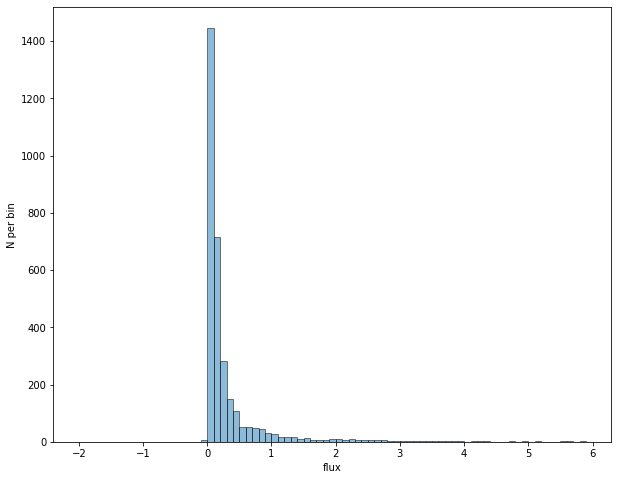

In [98]:
n = len(flux)  #number of points

width = 0.1
histmin = np.floor(min(flux))
#histmax = np.ceil(max(flux)) + width
histmax = 6
bins = np.arange(histmin,histmax,width)
plt.hist(flux, bins=bins, alpha=0.5, edgecolor="black")
plt.ylabel("N per bin")
plt.xlabel("flux")
plt.savefig('f105whisto.png')

In [68]:
for i in flux:
    print(i)

0.03128196650415135
0.031017890744080887
-0.02438808820188799
0.0019470551797667176
0.0124572508809797
-0.011228221357596348
0.029367541099200017
-0.009126428874442363
0.048023204627388634
0.02783969057461945
0.10468203920347152
0.0449531737191137
0.014042986844433468
0.010265027012792414
0.011400379218644044
0.02556239139958052
0.016498321760445828
-0.008420184978749617
0.0069805112812900885
0.014791271445428722
-0.002137404118548158
0.0574246660040808
-0.0062781898693356234
0.03440726318345697
0.03159088319574948
0.018111103959381578
0.02386884585605003
0.02966461253061425
0.04478815509581181
0.03266771833528766
0.042503978599925184
0.002717998491461906
0.0052400624568690515
0.023936494042573028
0.04490622956538573
0.00953758420102076
0.01160293699358589
0.03399177901761504
0.007932385023887033
-0.024238066043471933
0.01876851282606367
0.015388115648529477
-0.0018036221666989237
0.03692335773914237
-0.021197503797102415
0.0011066530256357429
0.005399179877931589
0.006591977050993589


#### Step 7 Mean, median, and standard deviation of the distribution of fluxes

In [96]:
print(f"Mean: {np.mean(flux)}")
print(f"Median: {np.median(flux)}")
print(f"Standard Deviation: {np.std(flux)}")

Mean: 0.9382356456101065
Median: 0.1120787098351866
Standard Deviation: 15.081402921667813


In [112]:
print(f"The largest outlier is: {max(flux)}")

The largest outlier is: 806.9677629280089


#### Where the outlier is

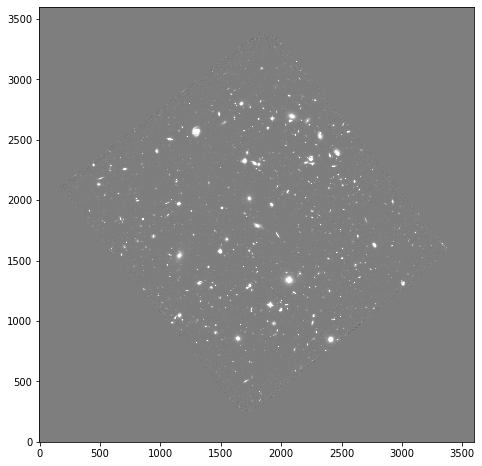

In [104]:
# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    if (i == max(flux)):
        e.set_edgecolor('red')
    ax.add_artist(e)

plt.savefig('f105woutlier.png')

In [107]:
for i in objects:
    print(i)

(0.00215929, 7, 6, 1742, 1744, 249, 251, 1742.94405837, 249.99267681, 0.54752973, 0.5108962, -0.25399617, 0.00331064, 0.00329292, -0.00164394, 0.88536364, 0.52398205, -0.7494033, 2.37386751, 2.54408455, 2.36037493, 0.01881527, 0.02599858, 0.00361211, 0.00546959, 1743, 250, 1742, 250, 0)
(0.00215929, 9, 8, 1767, 1770, 255, 258, 1768.62300226, 256.69505311, 0.87851834, 0.83835211, -0.45441456, 0.00339567, 0.00339147, -0.00169892, 1.14599013, 0.63527715, -0.76331472, 1.58175135, 1.65753448, 1.71472299, 0.02622999, 0.03809641, 0.00418212, 0.00658438, 1768, 257, 1770, 255, 0)
(0.00215929, 18, 16, 1718, 1721, 254, 259, 1719.10356686, 256.59046518, 0.70458633, 2.47116816, 0.32834301, 0.00102559, 0.00327973, 0.0003534, 1.59066689, 0.80345094, 1.3928473, 1.51295197, 0.43137705, -0.4020505, 0.06525383, 0.07852627, 0.00535476, 0.00770922, 1719, 255, 1719, 255, 0)
(0.00215929, 13, 13, 1698, 1702, 257, 260, 1699.41008, 258.964322, 1.56765884, 1.02271231, 0.62070797, 0.00355483, 0.00251965, 0.001415

(0.00215929, 25, 22, 2017, 2023, 522, 525, 2020.11218016, 523.47669263, 2.51413446, 1.08041481, -0.29407578, 0.00263176, 0.00094171, -0.00032808, 1.60377967, 1.01115775, -0.19464609, 0.41083106, 0.95600736, 0.22364645, 0.09680979, 0.10484082, 0.00656126, 0.00810174, 2020, 523, 2020, 523, 0)
(0.00215929, 7, 7, 1953, 1955, 524, 526, 1953.95331066, 524.95527409, 0.54839747, 0.54584247, 0.26275293, 0.00322435, 0.00322334, 0.00161779, 0.89993113, 0.53325784, 0.78296721, 2.37014151, 2.38123584, -2.28183651, 0.01904961, 0.0224644, 0.00317025, 0.00376379, 1954, 525, 1954, 525, 0)
(0.00215929, 34, 32, 1478, 1485, 522, 528, 1481.65791912, 525.08128933, 2.65273057, 2.46229951, -1.2674584, 0.00171901, 0.00154913, -0.0008671, 1.95666683, 1.13423336, -0.74790698, 0.4999221, 0.53858542, 0.5146656, 0.14135782, 0.15202889, 0.00751276, 0.00890906, 1481, 525, 1481, 525, 0)
(0.00215929, 10, 10, 2095, 2098, 524, 529, 2096.03229389, 526.35795409, 0.86221035, 2.65082037, -1.26331169, 0.0036272, 0.01140709, -

(0.00215929, 101, 93, 2223, 2235, 693, 704, 2227.76872811, 698.60084045, 4.94957727, 3.60127508, 0.07429461, 0.00025064, 0.00016231, 7.5218431e-06, 2.22568154, 1.89662695, 0.05488088, 0.20210004, 0.27776545, -0.00833868, 1.11008561, 1.11865771, 0.04380615, 0.0519601, 2228, 699, 2227, 699, 1)
(0.00215929, 20, 20, 1750, 1754, 702, 706, 1752.07081261, 703.92064499, 1.26696383, 1.36086905, 0.04099737, 0.00155706, 0.00172157, 0.00011056, 1.17313635, 1.11874211, 1.21190155, 0.79005867, 0.73554158, -0.04760242, 0.07470153, 0.08297423, 0.0060741, 0.00754869, 1752, 704, 1752, 704, 0)
(0.00215929, 31, 30, 2103, 2109, 702, 707, 2105.84004812, 704.30534107, 2.4263518, 1.72497035, 0.09763107, 0.00206008, 0.0014598, 0.00013052, 1.56195021, 1.3082943, 0.13576058, 0.41308215, 0.58104336, -0.04675982, 0.11337768, 0.11982371, 0.00594114, 0.00697248, 2106, 704, 2106, 704, 0)
(0.00215929, 50, 47, 1995, 2001, 708, 716, 1997.9055294, 712.14167028, 2.27024072, 3.18159324, -0.02900341, 0.00044078, 0.00064763,

(0.00215929, 22, 22, 1825, 1829, 854, 859, 1826.62309531, 856.2460305, 1.34949992, 1.77692484, -0.15764239, 0.00158672, 0.00204963, -0.00016388, 1.35232258, 1.13914382, -1.25302517, 0.74877512, 0.5686633, 0.13285728, 0.07943346, 0.08469573, 0.00508999, 0.00586397, 1826, 856, 1826, 856, 1)
(0.00215929, 37, 33, 1566, 1571, 854, 861, 1568.38322242, 857.96030209, 1.89560123, 2.95820738, 0.50121867, 0.00099716, 0.00157089, 0.00026446, 1.7768842, 1.30249429, 1.19266152, 0.55227929, 0.35389718, -0.18714893, 0.16100487, 0.16814749, 0.00784775, 0.00886934, 1568, 858, 1568, 858, 0)
(0.00215929, 21, 21, 2175, 2180, 858, 862, 2177.4918732, 859.87123744, 1.90558425, 1.16813627, -0.46633439, 0.00236448, 0.00155912, -0.0006302, 1.45991647, 0.97075462, -0.45088032, 0.5815922, 0.94875312, 0.46435755, 0.07467229, 0.08316654, 0.00539281, 0.00664969, 2178, 860, 2178, 860, 0)
(0.00215929, 28, 27, 2328, 2333, 858, 863, 2330.05305691, 860.72784701, 1.93885659, 2.03096467, 0.57316173, 0.0022231, 0.00232468, 0

(0.00215929, 130, 125, 2135, 2146, 915, 931, 2140.73140965, 922.62862837, 6.08497377, 13.61678446, 5.36689868, 0.00056154, 0.00116471, 0.00046752, 4.05058289, 1.81508553, 1.09132814, 0.25190994, 0.11257176, -0.19857481, 0.77685547, 0.79179519, 0.01372546, 0.01519406, 2141, 923, 2141, 923, 0)
(0.00215929, 17, 15, 2582, 2587, 928, 933, 2584.91532399, 929.83244417, 2.82154068, 2.10113509, 1.87188545, 0.00613051, 0.00448425, 0.0039955, 2.08987188, 0.74505764, 0.69034612, 0.86663222, 1.16377008, -1.54415226, 0.04823804, 0.0611427, 0.00358735, 0.0055178, 2584, 929, 2587, 932, 0)
(0.00215929, 21, 19, 2590, 2595, 927, 931, 2593.55151661, 928.27539352, 2.40972781, 1.56349475, -0.72866563, 0.0014977, 0.00104752, -0.00054629, 1.6820271, 1.06958282, -0.52235448, 0.4830606, 0.74451452, 0.4502601, 0.11382934, 0.15067334, 0.010341, 0.01590041, 2595, 928, 2595, 928, 1)
(0.00215929, 7, 6, 2592, 2595, 931, 933, 2594.00319058, 932.23382531, 0.8615838, 0.38296487, -0.0556384, 0.00290823, 0.00120779, -0.00

(0.00215929, 31, 27, 2666, 2672, 985, 992, 2669.24240358, 988.56936612, 1.50291468, 3.04559528, -1.11692634, 0.00052098, 0.00093648, -0.00039543, 1.9056859, 0.95753402, -1.0875901, 0.91466308, 0.45136023, 0.67087793, 0.20131889, 0.24514908, 0.01540406, 0.01952143, 2669, 988, 2670, 988, 0)
(0.00215929, 65, 61, 1717, 1724, 984, 993, 1720.86870301, 988.1972752, 3.44400931, 4.497173, -0.30097545, 0.00087745, 0.00116307, -4.14815051e-05, 2.13942003, 1.83413863, -1.31117201, 0.29206747, 0.2236701, 0.03909351, 0.31413233, 0.32314783, 0.01015312, 0.01144288, 1721, 988, 1721, 988, 0)
(0.00215929, 16, 16, 2529, 2533, 990, 993, 2531.04288131, 991.45397722, 1.26137108, 0.8898628, -0.02247671, 0.00251331, 0.00167704, -3.30266369e-06, 1.12371087, 0.94260693, -0.06020853, 0.79314512, 1.12427473, 0.04006751, 0.05278357, 0.05932274, 0.00482508, 0.00640927, 2531, 991, 2531, 992, 0)
(0.00215929, 27, 24, 2658, 2663, 989, 995, 2661.13195851, 991.65384212, 2.34987868, 2.06454332, -0.3437079, 0.00200307, 0.0

(0.00215929, 56, 54, 2496, 2502, 1059, 1068, 2498.62203944, 1064.23927673, 2.38323364, 4.38938493, -0.51652975, 0.0004875, 0.0009506, -8.19398342e-05, 2.12475085, 1.50268173, -1.33302999, 0.43057978, 0.23378497, 0.10133869, 0.33247897, 0.34154302, 0.01342297, 0.0153001, 2499, 1064, 2499, 1064, 1)
(0.00215929, 43, 42, 2404, 2410, 1062, 1069, 2406.99161765, 1065.83727186, 2.37936003, 2.61802043, -0.10667857, 0.00069814, 0.0007922, -3.21772561e-05, 1.63056827, 1.52925718, -1.20605731, 0.42105031, 0.38266709, 0.03431375, 0.2399776, 0.24997546, 0.01196841, 0.01407041, 2407, 1066, 2407, 1066, 0)
(0.00215929, 39, 37, 1954, 1960, 1065, 1071, 1957.17295828, 1068.2994117, 2.20583948, 2.52584399, 0.08159844, 0.00100407, 0.00110889, 1.45391281e-05, 1.59544659, 1.4785918, 1.33499527, 0.45388454, 0.39638096, -0.02932586, 0.18276387, 0.19120783, 0.00926828, 0.01138885, 1957, 1069, 1957, 1069, 0)
(0.00215929, 14, 12, 1047, 1050, 1070, 1073, 1048.37373421, 1071.74926411, 1.00413573, 0.91772895, -0.0469

(0.00215929, 129, 122, 2134, 2145, 1117, 1130, 2139.84751341, 1124.23282604, 4.71681674, 6.4576901, 0.5756031, 0.00016625, 0.00024474, 2.43895695e-05, 2.57503295, 2.13159847, 1.27866399, 0.21433881, 0.15655705, -0.03820997, 1.39685428, 1.4103086, 0.04491816, 0.05323224, 2140, 1125, 2140, 1125, 0)
(0.00215929, 40, 40, 2280, 2287, 1125, 1131, 2283.20433072, 1128.07417864, 2.99296171, 2.9452491, -1.09711743, 0.00222152, 0.00209131, -0.00081034, 2.01655197, 1.36811137, -0.77452761, 0.38695484, 0.39322343, 0.28828454, 0.13617095, 0.14329334, 0.00510105, 0.00544462, 2283, 1128, 2283, 1128, 0)
(0.00215929, 8, 8, 2389, 2391, 1128, 1131, 2390.37741878, 1129.2307572, 0.46155707, 0.9006471, 0.13877587, 0.00283891, 0.00549676, 0.00091549, 0.96996409, 0.64913315, 1.28894961, 2.27182961, 1.16425073, -0.70010799, 0.01994405, 0.02230909, 0.00280782, 0.0033669, 2390, 1129, 2390, 1129, 0)
(0.00215929, 29, 28, 2459, 2464, 1127, 1132, 2461.37619042, 1129.73502477, 1.76986662, 1.79016159, 0.06019532, 0.001

(0.00215929, 11, 11, 2912, 2917, 1201, 1204, 2915.27881511, 1202.97953591, 2.16956367, 0.91823868, -0.10932376, 0.00976827, 0.00379674, -0.00038779, 1.47615826, 0.95328867, -0.0864932, 0.46370408, 1.09561443, 0.11041547, 0.02771053, 0.03854881, 0.00300234, 0.0061022, 2916, 1202, 2916, 1201, 0)
(0.00215929, 6, 6, 2938, 2940, 1201, 1204, 2938.92768375, 1202.45067156, 0.64620964, 0.84217323, 0.61945567, 0.00350985, 0.00480119, 0.00350116, 1.17104578, 0.34210312, 0.86383533, 5.24734449, 4.0263505, -7.7193079, 0.01829503, 0.02861982, 0.00388306, 0.00673402, 2938, 1202, 2938, 1202, 0)
(0.00215929, 47, 44, 2747, 2754, 1199, 1205, 2750.13069147, 1202.10674446, 2.74654053, 2.27619008, -0.15271003, 0.00067902, 0.00051614, -2.44097717e-05, 1.67085958, 1.49363947, -0.28795758, 0.36545765, 0.44097558, 0.04903725, 0.29380718, 0.30480286, 0.01638232, 0.02077645, 2750, 1202, 2750, 1202, 0)
(0.00215929, 11, 9, 2930, 2932, 1201, 1205, 2930.94851995, 1202.53990306, 0.60148543, 1.74516011, -0.38258069, 0.

(0.00215929, 216, 209, 2088, 2105, 1216, 1233, 2098.04241716, 1226.4432018, 11.78580986, 12.77802335, 3.0402191, 0.00039925, 0.00042095, 8.23964607e-05, 3.91948295, 3.03339505, 0.86627597, 0.09039578, 0.08337654, -0.04301494, 1.76468611, 1.77277458, 0.02541636, 0.02776409, 2098, 1226, 2098, 1226, 1)
(0.00215929, 1048, 1023, 2087, 2135, 1220, 1258, 2113.41420198, 1235.60589245, 47.97514164, 30.94851917, -22.09999393, 4.95272252e-05, 3.44651813e-05, -1.72093201e-05, 7.94637442, 3.97225308, -0.60154891, 0.0310619, 0.0481509, 0.04436192, 27.09384346, 27.1180191, 0.18088733, 0.18997155, 2114, 1235, 2114, 1235, 1)
(0.00215929, 21, 20, 2541, 2545, 1253, 1258, 2542.80275262, 1255.64220008, 1.0411282, 2.24454801, 0.34141331, 0.00168648, 0.00332563, 0.0005948, 1.52795947, 0.97520047, 1.31274235, 1.01092148, 0.46891347, -0.30753812, 0.06682578, 0.07390349, 0.00441557, 0.00513049, 2543, 1256, 2543, 1256, 0)
(0.00215929, 14, 13, 2330, 2333, 1255, 1259, 2331.32431609, 1257.21277073, 0.83058049, 1.13

(0.00215929, 67, 65, 1848, 1858, 1321, 1327, 1852.65162123, 1323.97837295, 5.83814891, 2.7374536, -0.5471771, 0.00120209, 0.00052965, -8.42012955e-05, 2.43554425, 1.62595415, -0.16964504, 0.17455736, 0.37227729, 0.06978294, 0.36406177, 0.37771082, 0.01158083, 0.01320921, 1853, 1324, 1853, 1324, 0)
(0.00215929, 92, 87, 1421, 1430, 1309, 1324, 1425.81554671, 1317.47856229, 3.89984164, 6.55645795, -0.30109059, 0.00021302, 0.00057261, -1.96452631e-05, 2.56712961, 1.96625137, -1.45934355, 0.25733304, 0.15306407, 0.02363488, 0.78539634, 0.7928707, 0.02437583, 0.0278223, 1426, 1317, 1425, 1317, 1)
(0.00215929, 416, 402, 1427, 1453, 1301, 1328, 1438.39347233, 1317.5877388, 8.76461682, 9.83020168, -0.27532733, 3.61614838e-05, 4.50702629e-05, -4.02559604e-07, 3.14597154, 2.94918323, -1.33231246, 0.11419559, 0.10181689, 0.00639685, 10.59897041, 10.61249638, 0.33230439, 0.3972851, 1438, 1318, 1438, 1318, 1)
(0.00215929, 149, 140, 1405, 1424, 1310, 1322, 1413.18679482, 1315.91371294, 18.26762549, 5

(0.00215929, 17, 16, 2598, 2602, 1372, 1376, 2599.74638267, 1374.38056729, 1.09187918, 1.19781504, 0.1127295, 0.00154681, 0.0015865, 0.00021122, 1.1266768, 1.01009595, 1.00502431, 0.92483848, 0.84304488, -0.17407791, 0.06591814, 0.07281674, 0.00598312, 0.00798714, 2600, 1375, 2600, 1375, 0)
(0.00215929, 13, 12, 982, 985, 1374, 1377, 983.45518453, 1375.6417398, 1.09567776, 0.93989803, 0.37058753, 0.00392664, 0.00337357, 0.00136777, 1.18172431, 0.79943943, 0.68181616, 1.05311859, 1.22766352, -0.83045733, 0.0336208, 0.03704421, 0.00311281, 0.00374011, 984, 1376, 984, 1376, 0)
(0.00215929, 78, 74, 2283, 2295, 1348, 1356, 2287.97379333, 1352.89304301, 8.24665281, 4.4358992, -2.40254431, 0.00264916, 0.00132127, -0.0007869, 3.06719017, 1.80966771, -0.45014879, 0.14398016, 0.26766938, 0.15596329, 0.30915427, 0.31605458, 0.00811706, 0.00932612, 2288, 1353, 2288, 1353, 1)
(0.00215929, 378, 363, 2268, 2294, 1354, 1378, 2280.46132524, 1363.83928071, 23.98023586, 18.2555167, 5.07724407, 0.00045888,

(0.00215929, 39, 36, 988, 995, 1414, 1420, 991.7130874, 1416.72331442, 3.51752307, 2.35367865, -0.70929706, 0.00341521, 0.00223469, -0.00068864, 1.96292186, 1.42061234, -0.44186351, 0.30268437, 0.45235538, 0.18243198, 0.11501963, 0.11948902, 0.00420567, 0.00461636, 991, 1417, 991, 1417, 0)
(0.00215929, 30, 25, 1165, 1172, 1414, 1420, 1168.24240501, 1415.79472394, 4.24535194, 2.49397104, -1.63068659, 0.00664279, 0.00396132, -0.00269474, 2.28486323, 1.23236489, -0.53899157, 0.31455195, 0.53544474, 0.4113405, 0.0772076, 0.08107803, 0.00342262, 0.00386603, 1168, 1415, 1168, 1415, 0)
(0.00215929, 456, 442, 1792, 1818, 1395, 1420, 1805.14622822, 1407.4692512, 12.16535964, 12.66041468, 4.19574424, 3.46179823e-05, 3.00646102e-05, 8.60340181e-06, 4.0762639, 2.86528325, 0.81486148, 0.09280861, 0.08917955, -0.06151476, 12.60228157, 12.61953926, 0.24948438, 0.28185916, 1806, 1408, 1805, 1408, 0)
(0.00215929, 53, 51, 860, 867, 1414, 1421, 863.34217762, 1417.66786653, 2.48983759, 2.72928821, -0.0387

(0.00215929, 8, 6, 3242, 3246, 1473, 1474, 3244.06949798, 1473.60549386, 1.3866879, 0.23887105, -0.00322335, 0.00775149, 0.00120924, -6.9829839e-06, 1.17758095, 0.48873511, -0.00280822, 0.72116542, 4.18649054, 0.01946298, 0.02127388, 0.02709751, 0.00318645, 0.00481499, 3244, 1473, 3245, 1473, 0)
(0.00215929, 72, 68, 1831, 1841, 1465, 1475, 1835.66588187, 1469.99933584, 5.91051388, 5.35781481, -3.24097528, 0.00167782, 0.00150658, -0.00091206, 2.98109031, 1.54318786, -0.74286735, 0.25316277, 0.27927843, 0.30627945, 0.30596647, 0.31811449, 0.00859718, 0.01002623, 1835, 1471, 1835, 1471, 0)
(0.00215929, 437, 424, 1049, 1073, 1452, 1476, 1062.5077522, 1464.59977199, 16.39595126, 23.00527441, -5.47987428, 0.00014317, 0.00015472, -3.87496139e-05, 5.10879803, 3.64710975, -1.05672932, 0.06626624, 0.04722821, 0.03156934, 5.65337324, 5.67141008, 0.06630512, 0.07394391, 1063, 1464, 1063, 1464, 0)
(0.00215929, 214, 206, 1168, 1183, 1455, 1476, 1174.95208992, 1466.49195699, 7.89185682, 14.73767941, 

(0.00215929, 149, 145, 1305, 1322, 1540, 1552, 1314.3965726, 1544.89045798, 11.92598725, 5.22973051, -1.74675785, 0.00084132, 0.0003227, -0.00016651, 3.51486135, 2.19122529, -0.24043287, 0.08816351, 0.20104992, 0.05889416, 1.10953391, 1.12731957, 0.03282658, 0.03904178, 1315, 1545, 1315, 1545, 0)
(0.00215929, 9, 9, 2160, 2163, 1551, 1553, 2161.32358205, 1551.87061239, 0.83870145, 0.53109707, 0.14466232, 0.00412223, 0.00252042, 0.00068779, 0.94659626, 0.68829793, 0.37739238, 1.25109828, 1.97571778, -0.68155813, 0.02378223, 0.02638742, 0.00301662, 0.0034941, 2161, 1552, 2161, 1552, 0)
(0.00215929, 420, 405, 1515, 1547, 1532, 1554, 1533.50343962, 1541.59222965, 33.30189608, 16.80595622, 12.0509783, 0.00036853, 0.00016712, 0.00011529, 6.29739475, 3.2327497, 0.4853006, 0.0405506, 0.08035316, -0.0581549, 4.53289604, 4.55771971, 0.04642226, 0.05010527, 1532, 1540, 1532, 1540, 0)
(0.00215929, 93, 88, 2704, 2714, 1544, 1555, 2708.78047681, 1549.60572718, 3.62262497, 4.29954471, -0.44836918, 0.0

(0.00215929, 261, 249, 1090, 1108, 1594, 1616, 1098.93474487, 1602.8608585, 9.37925862, 11.90123871, 4.37619273, 0.00011318, 0.00013487, 5.80012082e-05, 3.89801168, 2.46698236, 0.92567217, 0.12869859, 0.10142619, -0.09464726, 3.9472928, 3.96681905, 0.08764934, 0.09986083, 1099, 1603, 1099, 1603, 0)
(0.00215929, 13, 13, 2940, 2942, 1613, 1617, 2941.0132166, 1614.72010664, 0.5896614, 1.36139983, -0.01927604, 0.00125983, 0.00327137, 7.5195304e-07, 1.1669966, 0.76758075, -1.54583967, 1.69667387, 0.73487818, 0.04804635, 0.04302303, 0.0492918, 0.00451194, 0.00528775, 2941, 1615, 2941, 1615, 0)
(0.00215929, 105, 92, 602, 614, 1559, 1571, 606.14717285, 1565.89817519, 8.80246721, 6.99772411, -1.58328041, 0.00090472, 0.00061269, -4.49301268e-05, 3.11808777, 2.46530342, -0.52638733, 0.11842392, 0.14896595, 0.05358836, 0.70681256, 0.7296648, 0.01907877, 0.02422007, 605, 1566, 604, 1566, 1)
(0.00215929, 166, 152, 594, 609, 1569, 1585, 599.0609351, 1575.64825331, 11.21497582, 15.96253054, -2.7530667

(0.00215929, 15, 15, 2220, 2224, 1670, 1673, 2221.48901687, 1671.5175573, 1.30716709, 1.0882077, -0.500034, 0.00397924, 0.00324943, -0.00151698, 1.30750382, 0.82813567, -0.67762649, 0.92816013, 1.11491621, 0.85298353, 0.03996188, 0.04536504, 0.00356652, 0.00406309, 2221, 1672, 2221, 1672, 1)
(0.00215929, 64, 58, 1995, 2006, 1668, 1675, 2000.35888706, 1671.95562177, 6.30665815, 2.65519874, -0.28445542, 0.00222691, 0.00091572, -8.90570046e-05, 2.5156877, 1.6227051, -0.07728052, 0.15933248, 0.37844834, 0.03413906, 0.26182345, 0.27073851, 0.00781003, 0.0087672, 2001, 1672, 2001, 1672, 0)
(0.00215929, 16, 14, 2477, 2481, 1672, 1675, 2479.02619404, 1673.5719732, 1.24464991, 0.92667038, 0.00584075, 0.00220981, 0.00148016, 2.77611823e-06, 1.11568689, 0.96258152, 0.01836006, 0.80346256, 1.07916427, -0.01012835, 0.05627016, 0.06268149, 0.00524594, 0.00647484, 2479, 1674, 2479, 1674, 0)
(0.00215929, 31, 31, 2974, 2979, 1670, 1675, 2976.58304751, 1672.72850168, 2.03567534, 2.03761222, -0.33321281,

(0.00215929, 5, 5, 2588, 2589, 1719, 1721, 2588.39469101, 1719.79051264, 0.23891002, 0.52805127, -0.10408833, 0.00238837, 0.00557311, -0.00119354, 0.74941576, 0.4531416, -1.25879049, 4.57891512, 2.07167125, 1.80517173, 0.01210085, 0.01387824, 0.00266393, 0.00320543, 2588, 1720, 2588, 1720, 0)
(0.00215929, 34, 30, 1859, 1865, 1717, 1722, 1861.7379785, 1719.53855778, 2.10124978, 1.80108463, 0.02550062, 0.00088237, 0.00068942, 3.60131102e-07, 1.45031059, 1.34124327, 0.08415163, 0.47598904, 0.55531639, -0.01347856, 0.18451943, 0.19403438, 0.01150237, 0.01457075, 1862, 1720, 1862, 1720, 0)
(0.00215929, 38, 36, 2941, 2946, 1715, 1722, 2943.59836094, 1719.00173758, 1.73911549, 2.83211701, 0.14082662, 0.00058144, 0.00095742, 6.16374151e-05, 1.68818545, 1.31196892, 1.44469571, 0.57732958, 0.35452023, -0.05741526, 0.21296026, 0.22333929, 0.01153417, 0.01404939, 2943, 1719, 2943, 1719, 0)
(0.00215929, 97, 90, 1171, 1181, 1713, 1723, 1176.12596019, 1717.88668673, 4.06537026, 3.75748248, 0.25467439

(0.00215929, 10, 10, 577, 580, 1776, 1778, 578.18141239, 1777.07210821, 0.89402972, 0.56264635, -0.01461725, 0.00349271, 0.00220107, -4.87464403e-06, 0.94587165, 0.74966848, -0.04399589, 1.1190064, 1.77807057, 0.05814238, 0.02830631, 0.03249408, 0.00354492, 0.00442421, 578, 1777, 578, 1777, 0)
(0.00215929, 37, 34, 1029, 1036, 1773, 1778, 1032.56266816, 1775.104703, 3.39105304, 1.54807017, 0.04382057, 0.00155404, 0.00069298, 4.18745924e-05, 1.84176397, 1.24379611, 0.02375908, 0.29500157, 0.64620191, -0.01670097, 0.17493992, 0.18334375, 0.00877468, 0.01013698, 1033, 1775, 1033, 1775, 0)
(0.00215929, 25, 25, 3160, 3165, 1772, 1777, 3162.06854516, 1774.39206671, 1.65809742, 2.0888938, 0.58252126, 0.00180815, 0.00232696, 0.00070192, 1.57941926, 1.11911845, 0.96248645, 0.66860467, 0.53071713, -0.3729021, 0.08730517, 0.09237938, 0.00513534, 0.00633402, 3162, 1774, 3162, 1774, 1)
(0.00215929, 111, 105, 3164, 3177, 1767, 1778, 3170.28057216, 1772.26206299, 5.86121006, 4.33259067, -0.01633926, 0

(0.00215929, 24, 23, 1372, 1376, 1821, 1826, 1373.97946891, 1823.28190933, 1.45714641, 1.71762501, -0.02649984, 0.00142167, 0.00165688, 1.62704153e-07, 1.31159961, 1.20601737, -1.47043121, 0.68646544, 0.58236265, 0.02118184, 0.09279583, 0.09970498, 0.0062202, 0.00762932, 1374, 1823, 1374, 1823, 0)
(0.00215929, 22, 20, 2903, 2908, 1822, 1826, 2905.49977229, 1824.36086771, 1.60304673, 1.27182821, -0.0188243, 0.00174884, 0.0012505, -1.69717604e-08, 1.26653588, 1.12728071, -0.05659059, 0.62392056, 0.7864064, 0.01846927, 0.08707248, 0.09444676, 0.00648433, 0.00797927, 2905, 1825, 2905, 1825, 0)
(0.00215929, 31, 26, 457, 463, 1822, 1827, 459.89130313, 1824.80490595, 2.54292595, 1.73364155, 0.51609361, 0.00199595, 0.00137672, 0.0004137, 1.67155457, 1.2175684, 0.45292908, 0.41853467, 0.61391163, -0.24919, 0.11909534, 0.12597609, 0.00666415, 0.00840594, 459, 1825, 459, 1825, 0)
(0.00215929, 23, 22, 1247, 1251, 1822, 1827, 1248.72085305, 1824.46995506, 1.2518916, 1.90401516, -0.1279959, 0.001591

(0.00215929, 32, 32, 677, 683, 1897, 1901, 679.95716881, 1898.97001228, 3.23790592, 1.49810904, -0.17103898, 0.00268802, 0.00137368, -0.00014125, 1.80404031, 1.21714985, -0.09707148, 0.3107155, 0.67155826, 0.07094872, 0.11083565, 0.11800873, 0.00562689, 0.00727844, 679, 1899, 678, 1899, 0)
(0.00215929, 9, 8, 337, 340, 1900, 1902, 338.15032719, 1900.86526734, 0.86771655, 0.51166011, -0.09783179, 0.00400407, 0.00220107, -0.00040353, 0.94489497, 0.69753152, -0.25124103, 1.17784154, 1.99748337, 0.45041755, 0.02545432, 0.03134977, 0.00383666, 0.00579566, 338, 1901, 338, 1901, 0)
(0.00215929, 9, 9, 588, 591, 1900, 1902, 589.33336337, 1901.13507118, 0.81367059, 0.51587387, -0.12046292, 0.00383496, 0.00234606, -0.00063916, 0.9253636, 0.68792927, -0.34011075, 1.27300799, 2.00787306, 0.59452617, 0.02465558, 0.02849514, 0.00335403, 0.00408267, 589, 1901, 589, 1901, 0)
(0.00215929, 40, 39, 1946, 1952, 1894, 1902, 1949.18393591, 1898.14067751, 2.09477625, 2.85592139, 0.21598287, 0.00088844, 0.00120

(0.00215929, 175, 170, 952, 969, 1971, 1984, 960.39149079, 1977.64477266, 6.79496146, 5.11974393, -1.44328342, 0.00010422, 7.14671578e-05, -2.32311018e-05, 2.76153612, 2.07089925, -0.52247554, 0.15654126, 0.2077627, 0.08825965, 2.94183969, 2.95428133, 0.1062118, 0.1307883, 960, 1978, 960, 1978, 0)
(0.00215929, 5, 5, 277, 278, 1984, 1986, 277.39781259, 1985.24441237, 0.23955773, 0.5323954, 0.10895451, 0.00217448, 0.00509156, 0.00108634, 0.75397986, 0.45107371, 1.25092971, 4.6027751, 2.07107425, -1.88391232, 0.01268141, 0.01504518, 0.00274222, 0.00377714, 277, 1985, 277, 1986, 0)
(0.00215929, 20, 18, 691, 696, 1983, 1986, 693.33482709, 1984.52518998, 2.27409913, 0.98503791, 0.28064548, 0.00475632, 0.00207246, 0.00059351, 1.52726853, 0.96259439, 0.20533422, 0.45575926, 1.05218458, -0.2596992, 0.05435603, 0.05783595, 0.003235, 0.00356296, 694, 1985, 692, 1984, 0)
(0.00215929, 34, 32, 2697, 2702, 1979, 1986, 2699.4523116, 1982.74160685, 1.92670507, 2.3562877, 0.23770546, 0.00104926, 0.00128

(0.00215929, 17, 16, 2944, 2948, 2045, 2049, 2946.3778455, 2047.00919425, 1.17016568, 1.19019525, -0.00937904, 0.00210592, 0.00230875, 3.7443726e-07, 1.09265792, 1.08002758, -1.19448161, 0.85463381, 0.84025133, 0.01346947, 0.05504032, 0.06032715, 0.00458186, 0.00557094, 2946, 2047, 2947, 2047, 0)
(0.00215929, 47, 45, 1614, 1620, 2044, 2052, 1616.8255108, 2048.26407497, 2.08032698, 3.76024506, -0.62570706, 0.00053636, 0.00096968, -0.00015849, 1.99190438, 1.3685354, -1.25067353, 0.50601935, 0.27995136, 0.16840386, 0.27046296, 0.282015, 0.01188124, 0.01378113, 1617, 2048, 1617, 2049, 0)
(0.00215929, 145, 136, 2673, 2687, 2040, 2052, 2679.68214008, 2046.30988078, 7.22500908, 5.02474582, 1.87864015, 0.00011181, 9.07942234e-05, 3.14791271e-05, 2.88130784, 1.98691225, 0.52051616, 0.15331244, 0.22044575, -0.1146402, 2.26498079, 2.27969766, 0.06368406, 0.07297363, 2680, 2047, 2681, 2047, 0)
(0.00215929, 19, 18, 969, 973, 2051, 2055, 971.27485964, 2052.75385079, 1.24769321, 1.42499536, -0.263132

(0.00215929, 33, 31, 1397, 1403, 2099, 2105, 1400.00598864, 2101.92298781, 2.32458919, 1.99358565, -0.02094445, 0.0018718, 0.00155801, 2.94063908e-06, 1.5250932, 1.41147637, -0.06294104, 0.43022427, 0.50165623, 0.0090398, 0.12223753, 0.12873857, 0.00644503, 0.00783834, 1400, 2102, 1400, 2102, 0)
(0.00215929, 24, 21, 1346, 1350, 2101, 2106, 1347.94948373, 2103.57236339, 1.47142709, 1.63132865, -0.20012955, 0.00131978, 0.00157282, -0.00015964, 1.32924283, 1.15579808, -0.97543371, 0.69114453, 0.62339908, 0.16957764, 0.09636972, 0.10326963, 0.00708972, 0.00884702, 1348, 2104, 1348, 2104, 0)
(0.00215929, 21, 20, 835, 839, 2104, 2108, 837.00179617, 2106.05056204, 1.40170109, 1.39729867, -0.01211346, 0.00211868, 0.00212202, 1.18843934e-07, 1.18819678, 1.17778945, -0.69552094, 0.71347231, 0.71572024, 0.01237046, 0.06838451, 0.07347298, 0.00506829, 0.0065689, 837, 2106, 837, 2106, 0)
(0.00215929, 15, 14, 852, 856, 2105, 2108, 854.08502435, 2106.33020087, 1.3097429, 0.80472384, 0.07582267, 0.003

(0.00215929, 7, 7, 343, 345, 2167, 2169, 344.30484748, 2167.933714, 0.46894441, 0.53438067, -0.010446, 0.00254623, 0.00299121, -6.5882197e-06, 0.73212552, 0.68360609, -1.41627479, 2.13337779, 1.87214041, 0.08340599, 0.01981619, 0.02411501, 0.00336552, 0.00442097, 344, 2168, 344, 2168, 0)
(0.00215929, 13, 13, 1038, 1041, 2166, 2169, 1039.13080038, 2167.51714426, 0.78300151, 1.0130914, 0.08652516, 0.00172505, 0.00224665, 0.00013705, 1.02078283, 0.86838657, 1.24837482, 1.28930497, 0.99648243, -0.22023152, 0.04445574, 0.05176355, 0.0048266, 0.00623825, 1039, 2167, 1039, 2168, 0)
(0.00215929, 16, 14, 246, 250, 2167, 2170, 247.54305853, 2168.29621101, 1.60757771, 1.03015782, -0.43118045, 0.00337364, 0.0018841, -0.00082878, 1.35564744, 0.89440227, -0.49038965, 0.70071983, 1.09348452, 0.58658332, 0.05071079, 0.06538217, 0.0047107, 0.0063984, 247, 2169, 247, 2169, 0)
(0.00215929, 23, 22, 1777, 1782, 2167, 2171, 1779.27083645, 2168.89428567, 1.70068748, 1.49215788, -0.23028508, 0.00240087, 0.002

(0.00215929, 94, 83, 1845, 1854, 2219, 2232, 1849.53495164, 2226.40219151, 2.97842645, 5.39653242, -0.17768949, 0.00015239, 0.00028869, -1.59592827e-06, 2.32583737, 1.72204506, -1.49783576, 0.33640859, 0.1856689, 0.02215359, 0.99727213, 1.00844491, 0.04290174, 0.05455529, 1850, 2226, 1850, 2226, 0)
(0.00215929, 21, 21, 2057, 2061, 2229, 2233, 2059.01592074, 2230.97871413, 1.4057242, 1.37369493, -0.03068221, 0.00187702, 0.00187725, -3.9282136e-07, 1.19344866, 1.1640873, -0.54487097, 0.71172404, 0.72831875, 0.03179347, 0.07265909, 0.07929672, 0.00538854, 0.00635296, 2059, 2231, 2059, 2231, 0)
(0.00215929, 25, 24, 1682, 1687, 2229, 2234, 1684.55724602, 2231.20835695, 1.57890962, 1.45117201, -0.22707807, 0.00103389, 0.00089306, -0.00014904, 1.32322705, 1.13099587, -0.6483081, 0.64792997, 0.70496321, 0.20277497, 0.1232915, 0.13305956, 0.00921111, 0.01190914, 1684, 2231, 1684, 2231, 0)
(0.00215929, 32, 26, 2613, 2619, 2229, 2235, 2616.0638459, 2231.8333152, 1.69599475, 2.48024937, 0.19310108

(0.00215929, 16, 16, 1189, 1192, 2297, 2301, 1190.62196132, 2299.2344123, 0.99686881, 1.2084832, 0.08091779, 0.0016458, 0.00213293, 0.00013915, 1.11170065, 0.98461854, 1.24435389, 1.008623, 0.83200562, -0.13507104, 0.05606131, 0.06244875, 0.00503186, 0.00617251, 1191, 2299, 1191, 2299, 0)
(0.00215929, 179, 176, 576, 597, 2255, 2265, 586.79947713, 2260.48247368, 12.96810727, 4.44952204, -0.37374013, 0.00016124, 3.87923449e-05, -9.06360208e-06, 3.60339737, 2.10550618, -0.04376141, 0.07729938, 0.2252886, 0.01298561, 3.13482404, 3.13867784, 0.08030058, 0.09142513, 587, 2260, 587, 2260, 1)
(0.00215929, 95, 94, 579, 594, 2265, 2272, 586.54496205, 2268.08984939, 6.44414117, 3.153994, 0.34520323, 0.00012036, 3.62208682e-05, -3.78664911e-06, 2.54557848, 1.76583278, 0.10341976, 0.15609491, 0.31892821, -0.03416904, 1.84144294, 1.8574301, 0.06347453, 0.07482523, 587, 2268, 587, 2268, 1)
(0.00215929, 685, 672, 577, 611, 2262, 2303, 594.33088961, 2286.54709375, 22.27884459, 35.49790237, -3.23923475,

(0.00215929, 21, 21, 550, 556, 2370, 2373, 552.99411828, 2371.46126704, 2.09479821, 1.01670285, 0.29746091, 0.00258978, 0.00121484, 0.00042847, 1.47357571, 0.96957505, 0.25212228, 0.49806529, 1.02620578, -0.29144201, 0.07793356, 0.09213112, 0.00592585, 0.00766402, 553, 2371, 553, 2371, 0)
(0.00215929, 11, 11, 1478, 1481, 2371, 2373, 1479.62203783, 2371.89150767, 1.01888987, 0.59317206, 0.130755, 0.00351316, 0.00193539, 0.00045893, 1.027542, 0.74580121, 0.27542675, 1.01003253, 1.73492992, -0.44529006, 0.03226144, 0.03701629, 0.00371529, 0.00479862, 1479, 2372, 1479, 2372, 0)
(0.00215929, 16, 14, 1798, 1802, 2370, 2373, 1800.04035868, 2371.66763003, 1.58281241, 0.88518466, 0.25213322, 0.00442789, 0.00253786, 0.00070982, 1.29011488, 0.89643776, 0.31294227, 0.66181529, 1.18340218, -0.37701878, 0.04211085, 0.04556591, 0.00322611, 0.00377395, 1800, 2372, 1800, 2371, 0)
(0.00215929, 19, 17, 2617, 2621, 2368, 2373, 2619.0786855, 2370.6060388, 1.17696138, 2.32924389, -0.89370388, 0.00245245, 0.

(0.00215929, 56, 55, 2237, 2245, 2437, 2444, 2240.99824328, 2440.85499213, 3.08168388, 2.49038384, -0.3609121, 0.00039906, 0.00031192, -6.05781636e-05, 1.80349135, 1.52298605, -0.44223621, 0.3301006, 0.40847746, 0.09567786, 0.45860004, 0.47277039, 0.02472833, 0.03115639, 2241, 2441, 2241, 2441, 0)
(0.00215929, 17, 16, 2638, 2641, 2440, 2444, 2639.49234179, 2441.9078664, 0.98403502, 1.47760814, 0.12803907, 0.0019679, 0.00299868, 0.0003086, 1.228351, 0.97611326, 1.33149934, 1.0278126, 0.68448699, -0.17812593, 0.05195398, 0.05924903, 0.00430319, 0.00565455, 2640, 2442, 2640, 2442, 0)
(0.00215929, 101, 97, 2406, 2416, 2430, 2445, 2411.06634452, 2437.41705347, 4.58915205, 10.54405075, 2.576134, 0.0009701, 0.00238934, 0.00062623, 3.39172792, 1.9050945, 1.21416581, 0.2525413, 0.10991511, -0.12340233, 0.42512137, 0.43585193, 0.00881658, 0.00946479, 2411, 2437, 2412, 2437, 0)
(0.00215929, 121, 118, 1415, 1426, 2433, 2446, 1420.3282069, 2439.94513242, 5.34266378, 7.48373798, -1.02508218, 0.00043

(0.00215929, 118, 107, 2468, 2480, 2543, 2554, 2473.84062881, 2547.87343418, 4.64625386, 4.35702423, 0.37591097, 0.00012347, 0.00011506, 2.45177569e-06, 2.2145896, 2.02456665, 0.60177225, 0.21674007, 0.2311278, -0.03739937, 1.66136181, 1.6729598, 0.07189346, 0.09316699, 2474, 2548, 2474, 2548, 0)
(0.00215929, 71, 62, 2094, 2101, 2539, 2551, 2097.48893537, 2544.17881633, 2.85297846, 6.20229746, 0.42839144, 0.00066354, 0.00156274, 8.78222053e-05, 2.50124407, 1.67303729, 1.4455775, 0.35418421, 0.16292027, -0.04892686, 0.34442833, 0.35194695, 0.01227229, 0.01465271, 2097, 2544, 2097, 2544, 1)
(0.00215929, 21, 18, 2094, 2098, 2550, 2555, 2096.51827129, 2552.84395597, 1.20107948, 1.74617193, 0.11099128, 0.0012977, 0.00184192, 0.00018914, 1.32962596, 1.08597696, 1.37743092, 0.83750367, 0.576065, -0.10646787, 0.08409709, 0.09039219, 0.00637973, 0.00799463, 2096, 2553, 2097, 2553, 1)
(0.00215929, 12, 12, 1645, 1649, 2555, 2557, 1646.90216732, 2556.10189144, 1.64772999, 0.5600966, 0.39929761, 0.

(0.00215929, 43, 41, 1212, 1218, 2677, 2684, 1215.21838872, 2680.51181677, 2.53086558, 3.06567683, 0.69002394, 0.00121963, 0.00150754, 0.00034246, 1.88103628, 1.43465853, 0.97025377, 0.42095432, 0.3475183, -0.18949717, 0.18063089, 0.18880549, 0.00771868, 0.00914354, 1215, 2680, 1215, 2680, 0)
(0.00215929, 24, 22, 1870, 1877, 2680, 2684, 1873.51676793, 2682.21790074, 3.96789526, 1.22279675, -0.25523245, 0.0078852, 0.00235958, -0.0005421, 1.99785495, 1.09511077, -0.09192752, 0.25545257, 0.82892686, 0.10664043, 0.06139863, 0.0661793, 0.00308903, 0.00353773, 1873, 2681, 1874, 2682, 0)
(0.00215929, 507, 494, 1805, 1830, 2660, 2687, 1817.2418297, 2671.5037388, 21.85539858, 22.27766999, 0.94066692, 0.00011984, 0.00011642, -5.71571329e-06, 4.79902124, 4.59374189, 0.89579511, 0.04583859, 0.04496972, -0.00387104, 7.23561573, 7.26210785, 0.05914285, 0.06283908, 1817, 2671, 1817, 2671, 0)
(0.00215929, 55, 48, 1314, 1320, 2679, 2688, 1316.77298782, 2683.0678562, 2.33427026, 4.39887042, -0.02224716,

(0.00215929, 25, 24, 2046, 2051, 2828, 2833, 2048.31011154, 2830.97046343, 1.61690881, 1.73824368, -0.27377369, 0.00103941, 0.00108653, -0.00022322, 1.39928246, 1.18201578, -0.89443469, 0.63540906, 0.59105551, 0.20015407, 0.1234739, 0.12970401, 0.00867451, 0.0110535, 2048, 2831, 2049, 2831, 1)
(0.00215929, 635, 608, 1606, 1639, 2784, 2830, 1622.32846914, 2801.12115846, 7.84611174, 17.93685371, -0.18347129, 1.44348841e-05, 3.18681478e-05, -2.38873014e-07, 4.23558617, 2.80049586, -1.5526222, 0.12748216, 0.05576447, 0.00260796, 24.47576523, 24.49774551, 1.25199783, 1.6801033, 1622, 2801, 1622, 2801, 1)
(0.00215929, 3314, 3231, 1617, 1718, 2756, 2835, 1675.21224592, 2799.79971471, 58.21780828, 52.0567478, -3.58055029, 1.3068082e-05, 1.03345302e-05, -1.40362564e-06, 7.7369647, 7.10027695, -0.43016177, 0.01724985, 0.01929141, 0.00237295, 169.34532166, 169.41989136, 5.85324001, 7.88365269, 1675, 2800, 1675, 2800, 1)
(0.00215929, 207, 198, 1619, 1641, 2774, 2792, 1633.52866554, 2782.02239903, 

(0.00215929, 64, 62, 2201, 2213, 3007, 3015, 2207.44173796, 3010.50993959, 8.04235081, 3.14624883, -0.33374201, 0.00307183, 0.00124064, -0.00011726, 2.83989358, 1.76737213, -0.06774719, 0.12489152, 0.31924412, 0.02649603, 0.24334338, 0.25853336, 0.007956, 0.00948006, 2207, 3011, 2207, 3011, 0)
(0.00215929, 20, 17, 1474, 1478, 3011, 3016, 1476.18660359, 3013.16389671, 1.13257542, 1.82974315, -0.05955617, 0.0020822, 0.00335037, -4.9876725e-05, 1.35454571, 1.06184947, -1.48618734, 0.88445723, 0.54746181, 0.05757626, 0.05939098, 0.06309794, 0.00409906, 0.00512302, 1476, 3013, 1476, 3013, 0)
(0.00215929, 13, 13, 1497, 1500, 3013, 3016, 1498.55199708, 3014.13721569, 1.04548468, 0.78827936, 0.06999375, 0.00242762, 0.00186391, 0.00014664, 1.03116369, 0.87776172, 0.24921422, 0.96221411, 1.27617204, -0.17087591, 0.04276171, 0.04822221, 0.00451021, 0.00584653, 1499, 3014, 1499, 3014, 0)
(0.00215929, 7, 7, 1903, 1905, 3015, 3017, 1903.95506759, 3016.29441546, 0.5397167, 0.45019374, -0.01663575, 0.

(0.00215929, 64, 61, 2082, 2089, 3185, 3196, 2085.77411535, 3189.98228167, 2.57793844, 5.51756339, -0.63038937, 0.00043092, 0.00097844, -0.00010339, 2.37635112, 1.56475472, -1.36821544, 0.39905575, 0.18644845, 0.09118536, 0.40075126, 0.4215495, 0.01582282, 0.01926144, 2086, 3190, 2086, 3190, 0)
(0.00215929, 120, 112, 2054, 2068, 3193, 3207, 2059.07167597, 3200.32350634, 4.25021495, 7.4045149, -0.53224264, 0.00020616, 0.00031767, 1.71807603e-06, 2.73713398, 2.04030085, -1.40806139, 0.23741934, 0.13627945, 0.0341318, 1.20312405, 1.23275054, 0.03758734, 0.04530196, 2059, 3200, 2059, 3199, 0)
(0.00215929, 12, 12, 1591, 1593, 3202, 3208, 1591.99828996, 3205.3702788, 0.4296887, 3.82848924, -0.46406945, 0.00154857, 0.01256478, -0.00180685, 1.97248924, 0.6061883, -1.43750691, 2.67783046, 0.30054507, 0.64918524, 0.03360175, 0.04840501, 0.0037284, 0.00670562, 1592, 3207, 1592, 3204, 0)
(0.00215929, 12, 12, 2077, 2080, 3207, 3210, 2078.51203106, 3208.70484957, 0.84958401, 0.9337828, -0.22940344, 